In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def initialize(particlePerCell, nodeNum, domainHeight, dt, simulationTime, randomParticle):
    if randomParticle:
        particleNum = (nodeNum - 1) * (particlePerCell)   # Number of particles in 'x' dimension # 1D
        dx = domainHeight / (nodeNum - 1)  # Node spacing
        dp = domainHeight / (particleNum - 1)  # Particle spacing
        xI = np.arange(0, domainHeight + dx - 1e-15, dx)  # Node locations
        np.random.seed(0)  # Set random seed for reproducibility
        xp = np.zeros(particleNum)
        for i in range(nodeNum - 1):
            for ppc in range (particlePerCell):
                if i == 0:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
                    xp[particlePerCell*i] = 0
                elif i == nodeNum - 2:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
                    xp[particlePerCell*i + particlePerCell - 1] = domainHeight
                else:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
    else:
        particleNum = (nodeNum - 1) * (particlePerCell)  # Number of particles in 'y' dimension # 1D
        # particleNum = (nodeNum - 1) * (particlePerCell - 1) + 1
        dx = domainHeight / (nodeNum - 1)  # Node spacing
        dp = domainHeight / (particleNum - 1)  # Particle spacing
        xI = np.arange(0, domainHeight + dx - 1e-12, dx)  # Node locations
        xp = np.zeros(particleNum)
        for i in range(nodeNum - 1):
            for ppc in range (particlePerCell):
                if i == 0:
                    xp[particlePerCell*i + ppc] = dx * ppc / (particlePerCell) + dx * i
                    xp[particlePerCell*i] = 0
                elif i == nodeNum - 2:
                    xp[particlePerCell*i + ppc] = dx * (ppc+1) / particlePerCell + dx * i
                    xp[particlePerCell*i + particlePerCell - 1] = domainHeight
                else:
                    xp[particlePerCell*i + ppc] = dx * (ppc+1) / (particlePerCell+1) + dx * i
        # xp = np.linspace(0, domainHeight, particleNum)  # Particle locations

    # Node displacement
    uI = np.zeros_like(xI)

    # Node pressure
    pI = np.zeros_like(xI)

    # Total number of timesteps
    timeStepNum = simulationTime / dt

    # Midpoint between each particle
    midpoint = (xp[1:] - xp[:-1]) / 2 + xp[:-1]

    # Calculate each particle volume
    vp = midpoint[1:] - midpoint[:-1]
    vp = np.concatenate(([midpoint[0]], vp, [domainHeight - midpoint[-1]]))

    # Initialize normal vector
    n = np.zeros(particleNum)
    n[0] = -1  # Normal vector at y = 0 (Dirichlet BC)
    n[-1] = 1  # Normal vector at y = Ly (traction BC)

    return particleNum, dx, dp, xp, vp, xI, uI, pI, n, timeStepNum

In [3]:
def initialize_terzaghi(E, nu, kh, gammaf, nf, Kf):
    K = E / (3 * (1 - 2 * nu))  # Bulk modulus
    G = E / (2 * (1 + nu))  # Shear modulus
    kf = kh / gammaf  # Permeability
    Ks = K * 1e10  # Solid grain bulk modulus
    alpha = 1 - K / Ks  # Biot's coefficient
    Q_inv = (alpha - nf) / Ks + nf / Kf  # 1 / Q
    return kf, Ks, alpha, Q_inv, K, G

In [4]:
def GetRK(xI, dx, xp, supportNorm): # Node location, Node spacing, Particle location, Normalized RK approximation support size
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape functions
    dphi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        # if idx == 0 or particleNum-1 :
        #     support =  supportNorm * dx
        # else:
        #     support = supportNorm * dx
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I] - xp[idx]])  # Define P(xI - xp)
            # print(PxI)
            # print(w[I,idx])
            # print(np.outer(PxI,PxI))
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
            # print(M)
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xp[idx]])
            # print(PxI)
            Ploc = np.array([1, 0])
            PlocGrad = np.array([0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    return phi, dphi

In [5]:
def get_vc(phiU, dphiU, nodeNum, vp, n):
    eps = 1e-15
    ksiNum = np.zeros(nodeNum)
    ksiDen = np.zeros(nodeNum)

    for I in range(nodeNum):
        ksiNum[I] = np.dot(dphiU[I, :], vp)
        ksiNum[I] -= np.dot(phiU[I, :], n) * 1
        localParticle = np.abs(phiU[I, :]) > eps
        # print(phiU[I,:])
        # print(localParticle)
        ksiDen[I] = np.sum(vp[localParticle])
    # print(ksiDen)

    ksi = -ksiNum / ksiDen
    return ksi, eps


In [38]:
def pressure_stabilize(dx, dp, Ks, Kf, kf, alpha, nf, K, G, dt, p, xp, vp, xI, nodeNum, particleNum, supportNorm,particlePerCell):
    if p == 0 or p == particleNum - 1:
        h1 = dx / 2
        h2 = dp / 2
    else:
        h1 = dx
        h2 = dp
    Mb = Ks * Kf / (Kf * (alpha - nf) + Ks * nf)
    Mprime = (K + 4 * G / 3) / ((K + 4 * G / 3) / Mb + alpha ** 2)
    cv = kf * Mprime

    if 1 - 3 * cv * dt / (h2 ** 2) < 0:
        ef = 0
        ef_old = 0
    else:
        ef = (1 / Mprime) * (1 - 3 * cv * dt / (h1 ** 2)) * (1 + np.tanh(2 - 12 * cv * dt / (h1 ** 2))) * ((h1/h2)**(particlePerCell))
        ef_old = (1 / Mprime) * (1 - 3 * cv * dt / (h1 ** 2)) * (1 + np.tanh(2 - 12 * cv * dt / (h1 ** 2))) #* ((h1/h2)**(particlePerCell))

    if p == 0:
        xl = [xp[p] + vp[p] * (1 / 3), xp[p] + vp[p] * (2 / 3)]
    elif p == particleNum-1: # particleNum == 81
        xl = [xp[p] - vp[p] * (1 / 3), xp[p] - vp[p] * (2 / 3)]
    else:
        xl = [xp[p] - vp[p] * (1 / 4), xp[p] + vp[p] * (1 / 4)]
    vl = vp[p] / 2

    phiBar = np.zeros(nodeNum)
    phiU_L,dphiU_L = GetRK(xI, dx, xl, supportNorm)
    for l in range(2):
        phiBar += (1 / vp[p]) * phiU_L[:,l] * vl

    return phiBar, ef, ef_old

In [7]:
def nsni(xI,dx,xp,supportNorm,nodeNum,particleNum,domainheight):
    xpp=[]
    xpp.append(0)
    for p in range(particleNum-1):
        xpp.append((xp[p]+xp[p+1])/2)
    xpp.append(domainheight)
    xpp=np.array(xpp)

    MoI = np.zeros(particleNum)
    particleNum1 = len(xpp)

    w = np.zeros((nodeNum, particleNum1))  # Initialize vector for kernel function weights
    dphi_NS = np.zeros((nodeNum, particleNum1))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum1):
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xpp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I] - xpp[idx]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xpp[idx]])
            PlocGrad = np.array([0, 1])
            dphi_NS[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    ddphi_NS = np.zeros((nodeNum,particleNum))
    for p in range(particleNum):
        L1 = xp[p] - xpp[p]
        L2 = xpp[p+1] - xp[p]
        length = L1 + L2
        difference = abs(L2 - L1) / 2
        MoI[p] = length**3 / 12 + difference**2
        ddphi_NS[:,p] = dphi_NS[:,p] * -1 / length + dphi_NS[:,p+1] * 1 / length

    return ddphi_NS,MoI

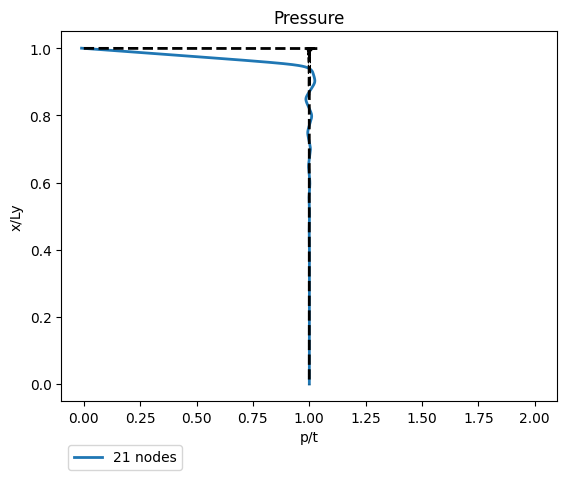

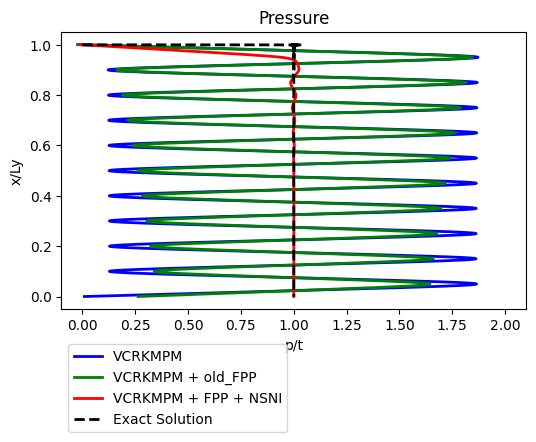

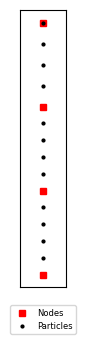

In [41]:
# 初始化參數
stabilization = True
stabilizationCoefficient = 1
SCNI_coeff=0
vc = True
randomParticle = False
E = 1e3
nu = 0
rho = 1
kh = 1e-5
gammaf = 10e3
nf = 0.2
Kf = 2.2e9
# nodeNumVector = [21]
domainHeight = 10
dt = 1
simulationTime = 1
betaNorm = 1000
supportNorm = 1.5
g = 0e1
traction = -1e1
dirichletBC = 0
tractionBC = domainHeight
# errorVector = np.zeros(len(nodeNumVector))
# dxVector = np.copy(errorVector)
NSNI = True

# 進行初始化和其他設置
particlePerCell_array = [4]
nodeNum_array = [21]
L2_norm = np.zeros((len(particlePerCell_array),2))

for idx in range(len(nodeNum_array)):
    particlePerCell = particlePerCell_array[0]
    nodeNum = nodeNum_array[idx]
    particleNum, dx, dp, xp, vp, xI, uI, pI, n, timeStepNum = initialize(particlePerCell, nodeNum, domainHeight, dt, simulationTime, randomParticle)
    uI1 = np.copy(uI)
    pI1 = np.copy(pI)
    uI_FPP = np.copy(uI)
    pI_FPP = np.copy(pI)
    uI_FPP_old = np.copy(uI)
    pI_FPP_old = np.copy(pI)
    uI_NSFPP = np.copy(uI)
    pI_NSFPP = np.copy(pI)
    kf, Ks, alpha, Q_inv, K, G = initialize_terzaghi(E, nu, kh, gammaf, nf, Kf)

    beta = betaNorm * E / dx
    zeroMatrix = np.zeros((nodeNum, nodeNum))
    Kuu = np.copy(zeroMatrix)
    Kuu1 = np.copy(zeroMatrix)
    Kup = np.copy(zeroMatrix)
    Kpu = np.copy(zeroMatrix)
    KppS = np.copy(zeroMatrix)
    KppH = np.copy(zeroMatrix)
    S = np.copy(zeroMatrix)
    S_old = np.copy(zeroMatrix)
    F = np.zeros(nodeNum)
    Q = np.copy(F)

    for i in range(int(simulationTime/dt)):
        phiU, dphiU = GetRK(xI, dx, xp, supportNorm)
        phiP, dphiP = GetRK(xI, dx, xp, supportNorm)
        phiU_VC, dphiU_VC = GetRK(xI, dx, xp, supportNorm)
        phiP_VC, dphiP_VC = GetRK(xI, dx, xp, supportNorm)

        if vc:
            ksi, eps = get_vc(phiU_VC, dphiU_VC, nodeNum, vp, n)

        checkVC = 0

        if NSNI:
            ddphi, MoI = nsni(xI,dx,xp,supportNorm,nodeNum,particleNum,domainHeight)

        for p in range(particleNum):
            if vc:
                withinSupport = phiU_VC[:, p] > eps
                dphiU_VC[:, p] = dphiU_VC[:, p] + ksi * withinSupport
                dphiP_VC[:, p] = dphiP_VC[:, p] + ksi * withinSupport
            checkVC = checkVC + np.dot(dphiU_VC[:, p], vp[p]) - np.dot(phiU_VC[:, p], n[p]) * 1

            Kuu = Kuu + E * np.outer(dphiU_VC[:, p], dphiU[:, p]) * vp[p]
            Kuu1 = Kuu1 + E * np.outer(dphiU_VC[:, p], dphiU[:, p]) * vp[p]
            Kup = Kup + alpha * np.outer(dphiU_VC[:, p], phiP[:, p]) * vp[p]
            KppS = KppS + Q_inv * np.outer(phiP[:, p], phiP[:, p]) * vp[p]
            KppH = KppH + kf * np.outer(dphiP_VC[:, p], dphiP[:, p]) * vp[p]
            F = F + phiU[:, p] * rho * g * vp[p]
            if NSNI:
                Kuu1 = Kuu1 + E * np.outer(ddphi[:,p], ddphi[:,p]) * MoI[p]
                # KppH += Kf * np.outer(ddphi[:,p], ddphi[:,p]) * MoI[p]

            if xp[p] == tractionBC:
                F = F + phiU[:, p] * traction * 1

            if stabilization:
                phiBar, ef ,ef_old = pressure_stabilize(dx, dp, Ks, Kf, kf, alpha, nf, K, G, dt, p, xp, vp, xI, nodeNum, particleNum, supportNorm,particlePerCell)
                # print(ef)
                S = S + stabilizationCoefficient * ef * np.outer(phiP[:, p] - phiBar,phiP[:, p] - phiBar) * vp[p]
                S_old = S_old + stabilizationCoefficient * ef_old * np.outer(phiP[:, p] - phiBar,phiP[:, p] - phiBar) * vp[p]

        J = np.block([[Kuu, -Kup], [-Kup.T, (-KppS - dt * KppH)]])
        J1 = np.block([[Kuu1, -Kup], [-Kup.T, (-KppS - dt * KppH)]])
        J_FPP = np.block([[Kuu, -Kup], [-Kup.T, (-KppS - dt * KppH - S)]])
        J_FPP_old = np.block([[Kuu, -Kup], [-Kup.T, (-KppS - dt * KppH - S_old)]])
        J_NSFPP = np.block([[Kuu1, -Kup], [-Kup.T, (-KppS - dt * KppH - S)]])
        Ext = np.concatenate([F, -dt * Q])
        R = np.block([[zeroMatrix, zeroMatrix], [-Kup.T, (-KppS)]])
        R_FPP = np.block([[zeroMatrix, zeroMatrix], [-Kup.T, (-KppS - S)]])
        R_FPP_old = np.block([[zeroMatrix, zeroMatrix], [-Kup.T, (-KppS - S_old)]])
        R_NSFPP = np.block([[zeroMatrix, zeroMatrix], [-Kup.T, (-KppS - S)]])
        J = np.delete(J, 0, axis=0)
        J = np.delete(J, 0, axis=1)
        J = np.delete(J, -1, axis=0)
        J = np.delete(J, -1, axis=1)
        J1 = np.delete(J1, 0, axis=0)
        J1 = np.delete(J1, 0, axis=1)
        J1 = np.delete(J1, -1, axis=0)
        J1 = np.delete(J1, -1, axis=1)
        J_FPP = np.delete(J_FPP, 0, axis=0)
        J_FPP = np.delete(J_FPP, 0, axis=1)
        J_FPP = np.delete(J_FPP, -1, axis=0)
        J_FPP = np.delete(J_FPP, -1, axis=1)
        J_FPP_old = np.delete(J_FPP_old, 0, axis=0)
        J_FPP_old = np.delete(J_FPP_old, 0, axis=1)
        J_FPP_old = np.delete(J_FPP_old, -1, axis=0)
        J_FPP_old = np.delete(J_FPP_old, -1, axis=1)
        J_NSFPP = np.delete(J_NSFPP, 0, axis=0)
        J_NSFPP = np.delete(J_NSFPP, 0, axis=1)
        J_NSFPP = np.delete(J_NSFPP, -1, axis=0)
        J_NSFPP = np.delete(J_NSFPP, -1, axis=1)
        R = np.delete(R, 0, axis=0)
        R = np.delete(R, 0, axis=1)
        R = np.delete(R, -1, axis=0)
        R = np.delete(R, -1, axis=1)
        R_FPP = np.delete(R_FPP, 0, axis=0)
        R_FPP = np.delete(R_FPP, 0, axis=1)
        R_FPP = np.delete(R_FPP, -1, axis=0)
        R_FPP = np.delete(R_FPP, -1, axis=1)
        R_FPP_old = np.delete(R_FPP_old, 0, axis=0)
        R_FPP_old = np.delete(R_FPP_old, 0, axis=1)
        R_FPP_old = np.delete(R_FPP_old, -1, axis=0)
        R_FPP_old = np.delete(R_FPP_old, -1, axis=1)
        R_NSFPP = np.delete(R_NSFPP, 0, axis=0)
        R_NSFPP = np.delete(R_NSFPP, 0, axis=1)
        R_NSFPP = np.delete(R_NSFPP, -1, axis=0)
        R_NSFPP = np.delete(R_NSFPP, -1, axis=1)
        Ext = np.delete(Ext, [0, -1])

        X = np.linalg.solve(J, np.dot(R, np.concatenate([uI[1:], pI[:-1]])) + Ext)
        X1 = np.linalg.solve(J1, np.dot(R, np.concatenate([uI1[1:], pI1[:-1]])) + Ext)
        X_FPP = np.linalg.solve(J_FPP, np.dot(R_FPP, np.concatenate([uI_FPP[1:], pI_FPP[:-1]])) + Ext)
        X_FPP_old = np.linalg.solve(J_FPP_old, np.dot(R_FPP_old, np.concatenate([uI_FPP_old[1:], pI_FPP_old[:-1]])) + Ext)
        X_NSFPP = np.linalg.solve(J_NSFPP, np.dot(R_NSFPP, np.concatenate([uI_NSFPP[1:], pI_NSFPP[:-1]])) + Ext)
        uI = np.concatenate([[0], X[:nodeNum - 1]])
        pI = np.concatenate([X[nodeNum - 1:], [0]])
        uI1 = np.concatenate([[0], X1[:nodeNum - 1]])
        pI1 = np.concatenate([X1[nodeNum - 1:], [0]])
        uI_FPP = np.concatenate([[0], X_FPP[:nodeNum - 1]])
        pI_FPP = np.concatenate([X_FPP[nodeNum - 1:], [0]])
        uI_FPP_old = np.concatenate([[0], X_FPP_old[:nodeNum - 1]])
        pI_FPP_old = np.concatenate([X_FPP_old[nodeNum - 1:], [0]])
        uI_NSFPP = np.concatenate([[0], X_NSFPP[:nodeNum - 1]])
        pI_NSFPP = np.concatenate([X_NSFPP[nodeNum - 1:], [0]])

    step = 0.005
    xc = np.arange(0, domainHeight + step, step)
    phiUc, dphiUc = GetRK(xI, dx, xc, supportNorm)
    uc = np.dot(uI, phiUc)
    pc = np.dot(pI, phiUc)
    pc1 = np.dot(pI1, phiUc)
    pc_FPP = np.dot(pI_FPP, phiUc)
    pc_FPP_old = np.dot(pI_FPP_old, phiUc)
    pc_NSFPP = np.dot(pI_NSFPP, phiUc)

    Z = xc / domainHeight
    pe = 0
    for m in range(10001):  # 注意迴圈範圍的調整
        M = np.pi * (2 * m + 1) / 2
        pe += (2 / M) * np.sin(M * Z)

    # error = abs(np.flip(pe) - pc_FPP / abs(traction))
    # L2_norm[idx,:] = [dp,np.sum(error)]
    # L2_norm[idx,:] = [dx,np.sqrt(np.trapz(error**2,xc))]

    plt.figure(1)
    plt.plot(pc_NSFPP / abs(traction), Z, linewidth=2)
    plt.xlabel('p/t')
    plt.ylabel('x/Ly')
    plt.legend(['21 nodes','41 nodes','81 nodes'],bbox_to_anchor=(0, -0.1),loc=2)
    plt.title('Pressure')
    plt.xlim([-0.1, 2.1])


plt.figure(1)
plt.plot(pe, 1-Z, 'k--', linewidth=2)
# plt.plot(xI, uI, 'r-', linewidth=3)
# plt.xlabel('Position')
# plt.ylabel('Displacement')
# plt.legend(['RKMPM'])
# plt.title('Displacement')

# plt.figure(2,(6,3.6))
# plt.plot(pc / abs(traction), Z, 'b-', linewidth=2,label='VCRKMPM')
# plt.plot(pc1 / abs(traction), Z, 'y--', linewidth=2,label='VCRKMPM + NSNI')
# plt.plot(pe, 1-Z, 'k--', linewidth=2,label='Exact Solution')
# plt.xlabel('p/t')
# plt.ylabel('x/Ly')
# plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
# plt.title('Pressure')
# plt.xlim([-0.1, 2.1])

plt.figure(3,(6,3.6))
plt.plot(pc / abs(traction), Z, 'b-', linewidth=2,label='VCRKMPM')
plt.plot(pc_FPP_old / abs(traction), Z, 'g-', linewidth=2,label='VCRKMPM + old_FPP')
# plt.plot(pc_FPP / abs(traction), Z, 'r-', linewidth=2,label='VCRKMPM + FPP')
plt.plot(pc_NSFPP / abs(traction), Z, 'r-', linewidth=2,label='VCRKMPM + FPP + NSNI')
plt.plot(pe, 1-Z, 'k--', linewidth=2,label='Exact Solution')
plt.xlabel('p/t')
plt.ylabel('x/Ly')
plt.legend(bbox_to_anchor=(0, -0.1),loc=2)
plt.title('Pressure')
plt.xlim([-0.1, 2.1])

# print(L2_norm)
# plt.figure(4,(6,3.6))
# plt.plot(L2_norm[:,0],L2_norm[:,1],'k-o',lw=2)
# plt.title('error of pressure with different ParticlePerCell')
# plt.xlabel('dp')
# plt.ylabel('error')

plt.figure(5,(0.6,3.6))
plt.plot(xI[17:] * 0, xI[17:], 'rs', markersize=4, linewidth=2)
plt.plot(xp[17*particlePerCell:] * 0, xp[17*particlePerCell:], 'ko', markersize=2)
plt.xticks([])
plt.yticks([])
plt.legend(['Nodes','Particles'],bbox_to_anchor=(0.5, -0.05),loc=9,fontsize=6)
plt.show()

In [9]:
stabilization = True
stabilizationCoefficient = 1
vc = True
randomParticle = False

E = 1
nu = 0
rho = 1
kh = 1e-5
gammaf = 10e3
nf = 0.2
Kf = 2.2e9

particlePerCell = 2
domainHeight = 1
dt = 1e-6
simulationTime = dt*10

betaNorm = 1000
supportNorm = 1.5
amp = 1e0

g = 0e1
# traction = -1e1
# qf = 0

t0 = dt*0


In [10]:
print("\U0001F600","\U0001F618","\U0001F917","\U0001F62A","\U0001F637","\U0001F607")
print("\U0001f600","\U0001F923","\U0001F606","\U0001F612","\U0001F910")

import numpy as np

nodeNumVector = 2**(np.arange(2, 7)) + 1  # Number of nodes
print(nodeNumVector)

😀 😘 🤗 😪 😷 😇
😀 🤣 😆 😒 🤐
[ 5  9 17 33 65]
